In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress
from random import sample as random_sample


#### Load Recipes Data

In [2]:
recipes = json.load(open('./data/recipe_train.json'))

for dic in recipes:
    ingredients = []
    for ingredient in dic['ingredients']:
        tmp_ingredient = ingredient.replace(' ', '-')
        ingredients.append(tmp_ingredient)
        dic['ingredients'] = ingredients

#### Convert recipe to text document

In [3]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [4]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True, token_pattern=r"(?u)\b\w[\w-]*\w\b")
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [5]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

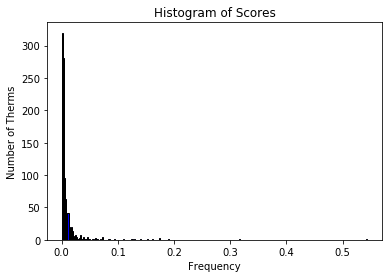

In [6]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [21]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    # print('-------------')
    # print(k)
    # print(scores_df.iloc[:15,:])


#### Load Baskets Market Data

In [8]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Compute ngram for tf.idf top score 

In [9]:
top_scores_ngram = {}
CUISINE_TOP_SCORE_THRESHOLD = 0.1
for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>CUISINE_TOP_SCORE_THRESHOLD]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [10]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs

In [11]:
baskets_scores = []

for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        sims = 0
        for item in basket:      
            item_ngram = list(ngrams(item, 3))
            for ngram_term, score in top_scores_ngram[cuisine]:
                sim = jaccard_distance(item_ngram, ngram_term)
                if sim > 0.2:
                    value += sim * score
                    sims += sim
        if sims != 0:
            value = value/sims
        else:
            value=0
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 
baskets_scores_df = pd.DataFrame(baskets_scores)
baskets_scores_df=(baskets_scores_df-baskets_scores_df.mean())/baskets_scores_df.std()

#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [12]:
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [13]:
# OPTICS
optics = OPTICS(min_samples=50, max_eps=0.1, xi=.05, min_cluster_size=.05)
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

{0, 1, 2, -1}


/home/nepotu/anaconda3/envs/dataMiningProject/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [14]:
# K-Means
kMeans = KMeans(n_clusters=7, random_state=0).fit(X)
kMeans_labels = kMeans.labels_
print(set(kMeans_labels))

{0, 1, 2, 3, 4, 5, 6}


In [15]:
# DBSCAN 
from sklearn.metrics import jaccard_score
[eps, min_samples] = [0.35, 200]
dbScan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(X)
dbScan_labels = dbScan.labels_
print(set(dbScan_labels))
print([eps, min_samples])


{0, 1, 2, 3, 4, 5, -1}
[0.35, 200]


#### Analysis of the method
Observe size of created basket clusters

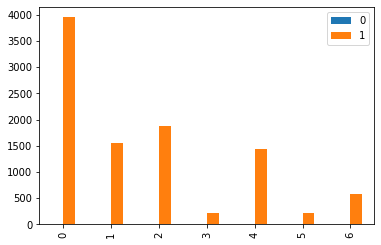

In [16]:
labels = kMeans_labels
cluster_sizes = []
for label in sorted(set(labels)):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')

Select one cluster and calculate its overall score (by summing
all scores of all items of that cluster)

In [17]:
for selected_basket_cluster in set(labels):
    print("Cluster ", selected_basket_cluster)
    selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
    print("#Baskets: ", selected_basket_scores.shape[0])
    aggregated_basket_cluster_score \
        = np.mean(selected_basket_scores, axis=0)\
        .sort_values(ascending=False)
    selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
    selected_baskets = [' '.join(l) for l in selected_baskets]
    aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
    print(aggregated_basket_cluster_score)

Cluster  0
#Baskets:  3950
greek          -0.389530
spanish        -0.434769
moroccan       -0.444325
italian        -0.478730
brazilian      -0.485855
korean         -0.502655
french         -0.528806
irish          -0.662205
filipino       -0.707451
cajun_creole   -0.726998
mexican        -0.765753
indian         -0.769794
jamaican       -0.794556
vietnamese     -0.820445
british        -0.832628
japanese       -0.859958
southern_us    -0.878863
chinese        -0.882689
thai           -0.897987
russian        -0.945171
dtype: float64
Cluster  1
#Baskets:  1555
korean          1.930007
filipino        1.476739
brazilian       1.353726
vietnamese      1.344811
japanese        1.342121
chinese         1.237034
spanish         1.182562
moroccan        1.158395
french          1.062002
jamaican        0.992574
thai            0.934325
indian          0.932630
russian         0.908703
italian         0.779298
mexican         0.718451
cajun_creole    0.689047
southern_us     0.624370
irish 

#### Baseline method - K-means
Now we will implement the baseline algorithm to compare our method with. 
A KNN method will be used. We will try to find the best K by trial and error based on the
coherence of the results because there are not many possible Ks for the given dataset.

In [18]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X_Baskets = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
model.fit(X_Baskets)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = set(model.labels_)
for i in baseline_labels:
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 beverages
 misc
 soda
 whole-milk
 shopping-bags
 bottled-water
 yogurt
 tropical-fruit
 other-vegetables
 pastry
Cluster 1:
 fruit
 vegetable-juice
 whole-milk
 soda
 yogurt
 other-vegetables
 bottled-water
 buns
 rolls
 tropical-fruit
Cluster 2:
 buns
 rolls
 whole-milk
 soda
 other-vegetables
 yogurt
 frankfurter
 bottled-water
 pastry
 newspapers
Cluster 3:
 canned-beer
 soda
 shopping-bags
 newspapers
 other-vegetables
 specialty-bar
 whole-milk
 pip-fruit
 pastry
 bottled-water
Cluster 4:
 soda
 pastry
 bottled-beer
 whole-milk
 other-vegetables
 shopping-bags
 specialty-bar
 frozen-meals
 chocolate
 specialty-chocolate
Cluster 5:
 newspapers
 yogurt
 whole-milk
 other-vegetables
 curd
 root-vegetables
 soda
 pastry
 margarine
 whipped
Cluster 6:
 tropical-fruit
 pip-fruit
 citrus-fruit
 whole-milk
 other-vegetables
 yogurt
 root-vegetables
 sour-cream
 whipped
 domestic-eggs
Cluster 7:
 sausage
 buns
 rolls
 soda
 whole-milk
 other-vegetables
 

#### Compute Scores of Baskets created using K-Means
For the created clusters of baskets using the baseline method, 
we calculate its scores in terms of similarity with the terms
that scored high TF-IDF for the cuisines 

In [19]:
baseline_baskets_scores = {}
for cluster in baseline_labels:
    basket_scores = baskets_scores_df[model.labels_ == cluster]
    cluster_scores = np.mean(basket_scores,axis=0).sort_values()
    np.argsort(cluster_scores)
    print(cluster_scores)

cajun_creole   -0.144205
thai           -0.125376
russian        -0.118813
southern_us    -0.109358
mexican        -0.104738
british        -0.099712
indian         -0.090958
irish          -0.087269
chinese        -0.077313
vietnamese     -0.067777
jamaican       -0.067260
japanese       -0.056763
filipino       -0.033605
italian        -0.018743
moroccan       -0.016729
greek          -0.015767
brazilian      -0.010879
spanish         0.002112
french          0.012290
korean          0.029263
dtype: float64
moroccan        0.171662
spanish         0.181256
brazilian       0.189556
korean          0.203340
greek           0.225828
italian         0.232826
french          0.237685
filipino        0.279730
irish           0.382358
mexican         0.402912
cajun_creole    0.427691
southern_us     0.439959
russian         0.447310
jamaican        0.451102
vietnamese      0.477439
british         0.479832
indian          0.517180
japanese        0.608627
thai            0.618373
chinese   